# Classification of CIFAR-10 datasets

Here are the steps: 

1. Use torchvision to load and preprocess CIFAR-10 datasets;
2. define network；
3. define loss fuction and optimizer；
4. train the NN and update parameters；
5. test the NN

**CIFAR-10**

CIFAR-10 is a frequently used graph datasets，it has 10 classifications: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'。Each graph is $3\times32\times32$，with resolution $32\times32$。

In [1]:
import torch as t
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from torch import optim
show = ToPILImage() # transfer Tensor to Image for visualization

In [2]:
import time 

## Preprocessing

In [3]:
# preprocessing
transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # Normalization

# train datasets
trainset = tv.datasets.CIFAR10(
    root = './pytorch-book-cifar10/',
    train=True,
    download=True,
    transform=transform
)

trainloader = t.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

# test datasets
testset = tv.datasets.CIFAR10(
    root = './pytorch-book-cifar10/',
    train=False,
    download=True,
    transform=transform
)

testloader = t.utils.data.DataLoader(
    testset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


ship


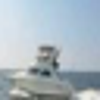

In [4]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2 to get data before normalization
show((data + 1) / 2).resize((100, 100))

**Dataloarder is a iterable object, it combine each data sample returned from datasets into one batch, providing multithreading accelerating optimization and data shuffle. When the programming iterates all the data, it iterates the Dataloader, too.**

      frog       deer      horse        dog


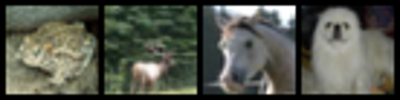

In [5]:
dataiter = iter(trainloader)

images, labels = next(dataiter)

print(' '.join('%10s'%classes[labels[j]] for j in range(4)))
          
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

## Define the NN

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # CIFAR-10 is 3-channel image datasets
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Defien Loss Function and Optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the NN

In [8]:
for epoch in range(3):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # input the data
        inputs, labels = data
        
        # empty grad
        optimizer.zero_grad()
        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # update parameters
        optimizer.step()
        
        # print log
        # loss is a scalar, use loss.item() not loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # print training status for every 2000 batches
            print('[%d, %5d] loss: %.2f' % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.17
[1,  4000] loss: 1.83
[1,  6000] loss: 1.67
[1,  8000] loss: 1.58
[1, 10000] loss: 1.51
[1, 12000] loss: 1.49
[2,  2000] loss: 1.38
[2,  4000] loss: 1.38
[2,  6000] loss: 1.34
[2,  8000] loss: 1.29
[2, 10000] loss: 1.27
[2, 12000] loss: 1.27
[3,  2000] loss: 1.19
[3,  4000] loss: 1.19
[3,  6000] loss: 1.18
[3,  8000] loss: 1.16
[3, 10000] loss: 1.17
[3, 12000] loss: 1.14
Finished Training


## Test

Actual label: 
       cat       ship       ship      plane


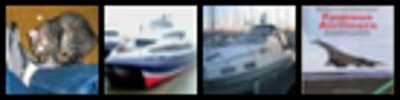

In [9]:
# Actual - Sample
dataiter = iter(testloader)
images,labels = next(dataiter)
print('Actual label: ')
print(' '.join('%10s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

In [10]:
# Predict - Sample
outputs=net(images) # calculate the score for each class
_, predicted = t.max(outputs.data, 1) # choose the class got the highest score

print('Predict label: ')
print(' '.join('%10s'%classes[predicted[j]] for j in range(4)))

# It is pretty accurate

Predict label: 
       cat       ship       ship       ship


In [11]:
correct = 0 
total = 0

with t.no_grad(): # shut down autograd to speed up and save memory
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum()
print('Accuracy: %.2d%%' % (100*correct//total))

Accuracy: 60%


## Improvement

In [12]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import time

In [13]:
# train test data
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
 
# preprocessing
transform = transforms.Compose(
            [torchvision.transforms.ColorJitter(0.5), 
             torchvision.transforms.RandomHorizontalFlip(),
            transforms.ToTensor()])

# train datasets
train_data = tv.datasets.CIFAR10(
    root = './pytorch-book-cifar10/',
    train=True,
    download=True,
    transform=transform
)

train_loader = t.utils.data.DataLoader(
    train_data,
    batch_size=128,
    shuffle=True
)

# test datasets
test_data = tv.datasets.CIFAR10(
    root = './pytorch-book-cifar10/',
    train=False,
    download=True,
    transform=transform
)

test_loader = t.utils.data.DataLoader(
    test_data,
    batch_size=128,
    shuffle=False
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [14]:
print(len(train_loader))

391


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
test_data_size = len(test_data)
train_data_size = len(train_data)
test_data_size,train_data_size

(10000, 50000)

In [17]:
loss_fn = nn.CrossEntropyLoss(reduction='mean')
loss_fn = loss_fn.to(device)

In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = conv_block(3, 32)   # 3,32,32
        self.conv2 = conv_block(32, 64, pool=True)  # 64,16,16
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))  # 64, 16, 16
        self.conv3 = conv_block(64, 128)  # 128, 16, 16
        self.conv4 = conv_block(128, 256,pool=True)  # 256, 8, 8
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))  # 256,8,8
        self.conv5 = conv_block(256, 512)  # 512, 8, 8
        self.conv6 = conv_block(512, 1024, pool=True)  # 1024, 4, 4
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))  # 1024, 4, 4
        self.linear1 = nn.Sequential(nn.MaxPool2d(4),  #1024,1,1
                                     nn.Flatten(),
                                     nn.Dropout(0.2),
                                     nn.Linear(1024, 10))
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.linear1(out)
        return out

In [19]:
model = Model()
model = model.to(device)

epoch = 11
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

time_able = True
running_loss = 0
total_train_step = 0
total_test_step = 0
if time_able:
    str_time = time.time()

for i in range(epoch):
    print(f'Epoch {i + 1}')
    model.train()
    lrs = []
    total_accuracy1 = 0
    for data in train_loader:
        imgs, targets = data
        imgs = imgs.to(device)
        targets = targets.to(device)
        output = model(imgs)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sched.step()
        lrs.append(get_lr(optimizer))
        total_train_step += 1
        if total_train_step % 200 == 0:
            if time_able:
                end_time = time.time()
                print(f'{end_time - str_time}')
            print(f'{total_train_step}th training，loss = {loss.item()},lr_last = {lrs[-1]}')
        accuracy1 = (output.argmax(1) == targets).sum()
        total_accuracy1 += accuracy1
        
    # test
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        model.eval()
        for data in test_loader:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, targets)
            total_test_loss = total_test_loss + loss
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy += accuracy
    total_test_loss = total_test_loss / test_data_size
    print(f'loss on testset = {total_test_loss}')
    print(f'accuracy on testset = {total_accuracy / test_data_size}')
    print(f'accuracy on trainet = {total_accuracy1 / train_data_size}')
    total_test_step += 1

Epoch 1
7.870603084564209
200th training，loss = 1.5089654922485352,lr_last = 0.0009587927472379
loss on testset = 0.009988611564040184
accuracy on testset = 0.5525999665260315
accuracy on trainet = 0.46531999111175537
Epoch 2
17.31361699104309
400th training，loss = 1.1901319026947021,lr_last = 0.002505067099632564
24.200841665267944
600th training，loss = 1.544617772102356,lr_last = 0.004678803518284779
loss on testset = 0.010896525345742702
accuracy on testset = 0.557200014591217
accuracy on trainet = 0.6151399612426758
Epoch 3
33.38254261016846
800th training，loss = 1.0084409713745117,lr_last = 0.006973890276048818
40.24003791809082
1000th training，loss = 1.3224949836730957,lr_last = 0.008855961608541227
loss on testset = 0.006727184168994427
accuracy on testset = 0.7131999731063843
accuracy on trainet = 0.6746000051498413
Epoch 4
49.426523208618164
1200th training，loss = 0.627278745174408,lr_last = 0.009886814261436531
56.28925085067749
1400th training，loss = 0.5418140888214111,lr_la